In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS test/train_data.txt')
data=data.drop(columns='ID')

test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS test/test_data.txt')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will remove the outlier of this dataset. --> use for numerical

In [ ]:
#  def remove_outliers(self):
#         Q1 = self.train[self.targets].quantile(0.25)
#         Q3 = self.train[self.targets].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_limit = Q1 - 1.5*IQR
#         upper_limit = Q3 + 1.5*IQR
#         self.train = self.train[(self.train[self.targets] >= lower_limit) & (self.train[self.targets] <= upper_limit)]
#         self.train.reset_index(drop=True, inplace=True)

In [99]:
data['86'].value_counts()

,count
86,
0,5474
1,348


Since the training dataset seem to be imbalanced, we will use SMOTE to oversample smaller classes.

In [100]:
#Split and Train data
X = data.drop(columns=['86'])
y = data['86']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(y_test.shape)

(4657, 85)
(4657,)
(1165,)


In [101]:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter(y_train)
print('Before', counter)

# oversampling the train dataset using SMOTE
smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After', counter)

Before Counter({0: 4390, 1: 267})
After Counter({0: 4390, 1: 4390})


In [102]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

models = {
    "Decision Tree" : DecisionTreeClassifier(random_state=42),
    "Random Forest" : RandomForestClassifier(random_state=42),
    "Logistic Regression" : LogisticRegression(random_state=42),
    "Support Vector Machine" : SVC(random_state=42),
    "Naive Bayes" : GaussianNB(),
    "XGBoost" : XGBClassifier(random_state=42),
    "LightGBM" : LGBMClassifier(random_state=42),

}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} Precision: {precision}")
    print(f"{name} Recall: {recall}")
    print(f"{name} ROC AUC: {roc_auc}")

Decision Tree Accuracy: 0.8841201716738197
Decision Tree Precision: 0.15384615384615385
Decision Tree Recall: 0.14814814814814814
Decision Tree ROC AUC: 0.5436312696460298
Random Forest Accuracy: 0.9141630901287554
Random Forest Precision: 0.08695652173913043
Random Forest Recall: 0.024691358024691357
Random Forest ROC AUC: 0.5026593321488771
Logistic Regression Accuracy: 0.9296137339055794
Logistic Regression Precision: 0.0
Logistic Regression Recall: 0.0
Logistic Regression ROC AUC: 0.49953874538745385
Support Vector Machine Accuracy: 0.9304721030042918
Support Vector Machine Precision: 0.0
Support Vector Machine Recall: 0.0
Support Vector Machine ROC AUC: 0.5
Naive Bayes Accuracy: 0.15622317596566523
Naive Bayes Precision: 0.07291666666666667
Naive Bayes Recall: 0.9506172839506173
Naive Bayes ROC AUC: 0.5237403762926518
XGBoost Accuracy: 0.9201716738197425
XGBoost Precision: 0.2
XGBoost Recall: 0.04938271604938271
XGBoost ROC AUC: 0.5173112842239533
[LightGBM] [Info] Number of posit

Since the XGBoost model seem to perform better than others, we will perform cross validation on this model.

In [103]:
import itertools
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score


param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create probaility for parameter
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# K-fold
def evaluate_model(params, X_train, y_train):
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    accuracy_scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Train model with parameter
        model = xgb.XGBClassifier(
            **params,
            objective='reg:squarederror',
            random_state=42
        )
        model.fit(X_train_fold, y_train_fold)

        # Predict accuracy
        y_pred = model.predict(X_val_fold)
        accuracy_scores.append(accuracy_score(y_val_fold, y_pred))

    # Mean of accuracy
    return np.mean(accuracy_scores)

# Best parameter
best_params = None
best_score = float('inf')

for params in param_combinations:
    print(f"Evaluating parameters: {params}")
    score = evaluate_model(params, X_train, y_train)
    print(f"Accuracy score: {score}")

    if score < best_score:
        best_score = score
        best_params = params

# Train the model with the best paramters
best_model = XGBClassifier(
    **best_params,
    objective='reg:squarederror',
    random_state=42
)
best_model.fit(X_train, y_train)

# Try on test data
y_pred_test = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("\nBest Parameters:", best_params)
print(f"Best Cross-Validated accuracy: {best_score}")
print(f"Test accuracy: {test_accuracy}")

Evaluating parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8, 'colsample_bytree': 0.8}
Accuracy score: 0.942665841304824
Evaluating parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8, 'colsample_bytree': 1.0}
Accuracy score: 0.942665841304824
Evaluating parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0, 'colsample_bytree': 0.8}
Accuracy score: 0.9424512029704175
Evaluating parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0, 'colsample_bytree': 1.0}
Accuracy score: 0.9424512029704175
Evaluating parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8, 'colsample_bytree': 0.8}
Accuracy score: 0.9424510646725217
Evaluating parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8, 'colsample_bytree': 1.0}
Accuracy score: 0.942236426338115
Evaluating parameters: {'learni

In [104]:

XGb = XGBClassifier(tree_method = "hist",
                              objective= 'binary:logistic',
                              eval_metric = "auc",
                              # 'random_state'= Config.state,
                              # 'early_stopping_rounds'= Config.early_stop,
                              verbosity= 0,
                              enable_categorical= True,
                              n_estimators= 5000,
                              # 'sample_pos_weight'= sample_pos_weight,
                              reg_lambda= 4.513971594758926,
                              reg_alpha= 1.7611316688753071,
                              colsample_bytree= 0.7659591609367851,
                              subsample= 0.9815427409107734,
                              learning_rate= 0.02343798614773425,
                              max_depth= 10,
                              min_child_weight = 1
)
XGb.fit(X_train, y_train)
y_pred = XGb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC AUC: {roc_auc}")

Accuracy: 0.9175965665236051
Precision: 0.17391304347826086
Recall: 0.04938271604938271
ROC AUC: 0.515927520386315


As we can see, after tuning the hyperparameter, the accuracy score seem to be higher.

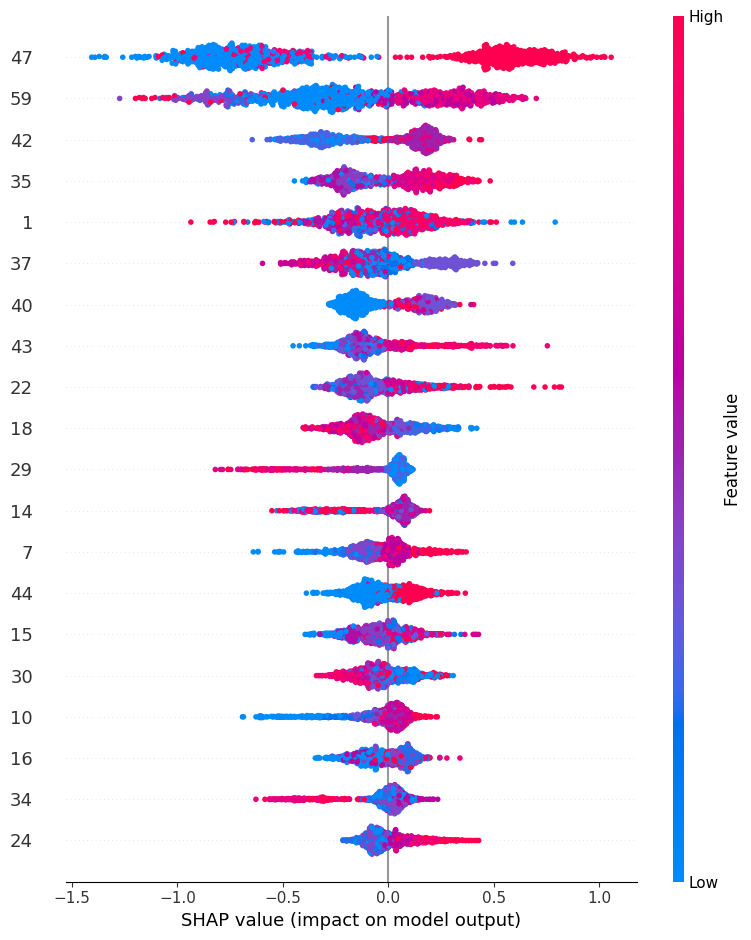

In [ ]:
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import shap
shap.initjs()

clf = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8, colsample_bytree=1.0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Feature 47, Feature 59, and Feature 42 have the highest impact on the model's output.

In [ ]:

X_test = test_data.drop(columns=['ID', 'predicted_probability'])  # Drop the ID column, keep features only

# Generate predictions (probabilities)
predictions = clf.predict(X_test)

# Add predictions to the test dataset
test_data['predicted_probability'] = predictions

# Select top 800 customers based on predicted probability
top_800 = test_data.nlargest(800, 'predicted_probability')

# Save the IDs of the top 800 customers to a CSV file
top_800[['ID']].to_csv('/content/drive/MyDrive/Colab Notebooks/AIA policy/top_800_customers.csv', index=False)

print("Top 800 customer IDs saved to 'top_800_customers.csv'")

Top 800 customer IDs saved to 'top_800_customers.csv'
